In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Feature engineering

In [2]:
df1=pd.read_csv("C:/Users/abhis/data/machine learning/books data/books.csv",sep=",")

In [3]:
df2=pd.read_csv("C:/Users/abhis/data/machine learning/books data/ratings.csv",sep=",")

In [4]:
df1.head(2)

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


In [5]:
df1=df1[["id","original_title","original_publication_year","authors"]]

In [6]:
df1.rename(columns={'id': 'book_id',"original_title":"title","original_publication_year":"year","authors":"author"}, inplace=True)

In [7]:
df1.head()

,book_id,title,year,author
0,1,The Hunger Games,2008.0,Suzanne Collins
1,2,Harry Potter and the Philosopher's Stone,1997.0,"J.K. Rowling, Mary GrandPré"
2,3,Twilight,2005.0,Stephenie Meyer
3,4,To Kill a Mockingbird,1960.0,Harper Lee
4,5,The Great Gatsby,1925.0,F. Scott Fitzgerald


In [8]:
sum(df1["title"].value_counts()>1)

123

In [9]:
df1.drop_duplicates(subset=["title"],keep="last",inplace=True)

In [10]:
df1.reset_index(drop=True,inplace=True)

In [11]:
df1.head()

,book_id,title,year,author
0,1,The Hunger Games,2008.0,Suzanne Collins
1,2,Harry Potter and the Philosopher's Stone,1997.0,"J.K. Rowling, Mary GrandPré"
2,4,To Kill a Mockingbird,1960.0,Harper Lee
3,5,The Great Gatsby,1925.0,F. Scott Fitzgerald
4,6,The Fault in Our Stars,2012.0,John Green


In [12]:
# df2 work
df2.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


<AxesSubplot:>

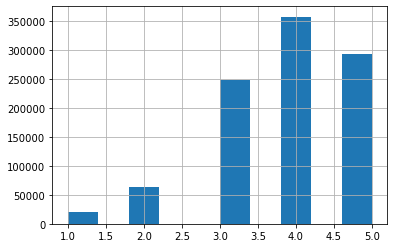

In [13]:
df2["rating"].hist()

In [14]:
df2["book_id"].max()

10000

In [15]:
df2.user_id.nunique()

53424

In [16]:
sum(df2.groupby(["book_id","user_id"]).count()["rating"]>1)

2209

In [17]:
df2.drop_duplicates(subset=["book_id","user_id"],keep="last",inplace=True)
df1.reset_index(drop=True,inplace=True)

In [18]:
df2.book_id.count()

979478

In [19]:
df2["book_id"].max()

10000

In [20]:
df_final=pd.merge(df2,df1,on="book_id",how="outer")

In [21]:
df_final.dropna(inplace=True,subset=["book_id","user_id","rating","title"])

In [22]:
df_final.head()

,book_id,user_id,rating,title,year,author
0,1,314,5,The Hunger Games,2008.0,Suzanne Collins
1,1,439,3,The Hunger Games,2008.0,Suzanne Collins
2,1,588,5,The Hunger Games,2008.0,Suzanne Collins
3,1,1169,4,The Hunger Games,2008.0,Suzanne Collins
4,1,1185,4,The Hunger Games,2008.0,Suzanne Collins


In [23]:
df_final["user_id"]=df_final["user_id"].astype(int)
df_final["book_id"]=df_final["book_id"].astype(int)

In [24]:
df_final[["book_id","user_id"]]=df_final.iloc[:,:2].iloc[:,::-1]

In [25]:
df_final=df_final.rename(columns={"book_id":"user_id","user_id":"book_id"})

In [26]:
df_final

,user_id,book_id,rating,title,year,author
0,314,1,5,The Hunger Games,2008.0,Suzanne Collins
1,439,1,3,The Hunger Games,2008.0,Suzanne Collins
2,588,1,5,The Hunger Games,2008.0,Suzanne Collins
3,1169,1,4,The Hunger Games,2008.0,Suzanne Collins
4,1185,1,4,The Hunger Games,2008.0,Suzanne Collins
...,...,...,...,...,...,...
979473,48386,10000,5,The First World War,1998.0,John Keegan
979474,49007,10000,4,The First World War,1998.0,John Keegan
979475,49383,10000,5,The First World War,1998.0,John Keegan
979476,50124,10000,5,The First World War,1998.0,John Keegan


In [27]:
df_final["book_id"].max()

10000

# Recommender system

In [43]:
from surprise import SVD,SVDpp,KNNBaseline,BaselineOnly
from surprise import Reader,Dataset
from surprise.model_selection import GridSearchCV,cross_validate,train_test_split
from surprise.accuracy import rmse

In [33]:
temp_df=df_final.sample(100000)
reader=Reader(rating_scale=(1,5))
data=Dataset.load_from_df(temp_df.iloc[:,0:3],reader)

In [34]:
algo_list=[SVD(),KNNBaseline(),BaselineOnly(),SVDpp()]
for algo in algo_list:
    cross_validate(algo,data,cv=3,measures=["rmse"],verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9289  0.9201  0.9260  0.9250  0.0037  
Fit time          3.76    3.57    3.45    3.59    0.13    
Test time         0.33    0.22    0.29    0.28    0.05    
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9554  0.9575  0.9574  0.9568  0.0010  
Fit time          34.69   35.49   34.39   34.86   0.47    
Test time         1.08    1.08    1.08    1.08    0.00    
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE o

In [35]:
# By rmse svdpp is best but fit time is very high. so i am going to use svd

In [36]:
param_grid = {'n_factors':[50,100],'n_epochs':[20,30],  'lr_all':[0.005,0.01],'reg_all':[0.02,0.1]}
svd = GridSearchCV(SVD,param_grid, measures = ['rmse'], cv = 3)
svd.fit(data)

In [37]:
svd.best_params

{'rmse': {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}}

In [38]:
reader=Reader(rating_scale=(1,5))
data=Dataset.load_from_df(df_final.iloc[:,0:3],reader)

In [39]:
model=SVD(n_factors=50,n_epochs=20,lr_all=0.01,reg_all=0.1)

In [40]:
trainset,testset=train_test_split(data,test_size=0.3)

In [41]:
model.fit(trainset)

In [42]:
predict_test=model.test(testset)
print(rmse(predict_test))

RMSE: 0.8359
0.8358676084822293


In [44]:
from collections import defaultdict
def prediction(user_id):
    book_pr=df_final[df_final["user_id"]==user_id]["book_id"].unique()
    books=df_final["book_id"].unique()
    not_rated_book=[]
    for i in books:
        if(i not in book_pr):
            not_rated_book.append(i)
    answer_pred=[]
    for i in not_rated_book:
        temp3=model.predict(user_id,i)
        answer_pred.append((i,temp3.est))
    answer_pred=sorted(answer_pred,key=lambda x:x[1],reverse=True)
    reading_list = defaultdict(list)
    for i in answer_pred[:10]:
        title = df1[df1["book_id"]==i[0]]["title"].unique()[0]
        reading_list[title] = i[1]
    for book, ratings in reading_list.items():
        print(f'{book}: {round(ratings,ndigits=2)}')

In [45]:
prediction(1185)

The Indispensable Calvin and Hobbes: A Calvin and Hobbes Treasury: 4.34
The Calvin and Hobbes Tenth Anniversary Book: 4.33
It's a Magical World: A Calvin and Hobbes Collection: 4.29
Words of Radiance: 4.28
Homicidal Psycho Jungle Cat: A Calvin and Hobbes Collection: 4.27
Saga, Volume Two: 4.27
Attack of the Deranged Mutant Killer Monster Snow Goons: A Calvin and Hobbes Collection: 4.25
A Court of Mist and Fury: 4.23
The Wise Man's Fear: 4.23
There's Treasure Everywhere: A Calvin and Hobbes Collection: 4.23
